In [1]:
%load_ext autoreload

In [2]:
%autoreload
import geopandas as gpd
import pandas as pd
import numpy as np
import fiona
import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.fill import fillnodata
from rasterio.plot import show
import nexus_tool.weap_tools as wp
import os
import matplotlib.pyplot as plt

## Reading files

In [4]:
provinces = gpd.read_file('Data - Souss-Massa/GIS/Admin/Provinces.gpkg')
groundwater = gpd.read_file('Data - Souss-Massa/Schematic/Groundwater.kml')
wwtp = gpd.read_file('Data - Souss-Massa/Schematic/Wastewater Treatment Plants.kml')
other_supply = gpd.read_file('Data - Souss-Massa/Schematic/Other Supplies.kml')
demand_sites = gpd.read_file('Data - Souss-Massa/Schematic/Demand Sites.kml')
catchments = gpd.read_file('Data - Souss-Massa/Schematic/Catchments.kml')
diversion = gpd.read_file('Data - Souss-Massa/Schematic/Diversions.kml')
reservoirs = gpd.read_file('Data - Souss-Massa/Schematic/Reservoirs.kml')
links = gpd.read_file('Data - Souss-Massa/Schematic/Transmission Links.kml')

## Converting geometries and dropping unecesary columns

In [5]:
for gdf in [groundwater, wwtp, other_supply, demand_sites, 
            catchments,diversion, reservoirs, links]:
    gdf['geometry'] = wp.polyz_to_poly(gdf)
    gdf.drop(columns='Description', inplace=True)

In [6]:
for gdf in [groundwater, wwtp, other_supply, 
            reservoirs]:
    gdf.rename(columns={'Name': 'point'}, inplace=True)

for gdf in [demand_sites, catchments]:
    gdf.rename(columns={'Name': 'point'}, inplace=True)

links.rename(columns={'Name': 'links'}, inplace=True)
diversion.rename(columns={'Name': 'diversion'}, inplace=True)

## Defining types

In [8]:
groundwater['type'] = 'Groundwater supply'
wwtp['type'] = 'WWTP'
other_supply['type'] = 'Other supply'
reservoirs['type'] = 'Reservoir supply'
catchments['type'] = 'Catchment'
demand_sites['type'] = 'Demand site'
diversion['type'] = 'Transmission Pipeline'
links['type'] = 'Transmission links'

In [9]:
other_supply['point'] = 'Prelevement 3'
supply_points = groundwater.append([wwtp, other_supply, reservoirs], ignore_index=True, sort=False)

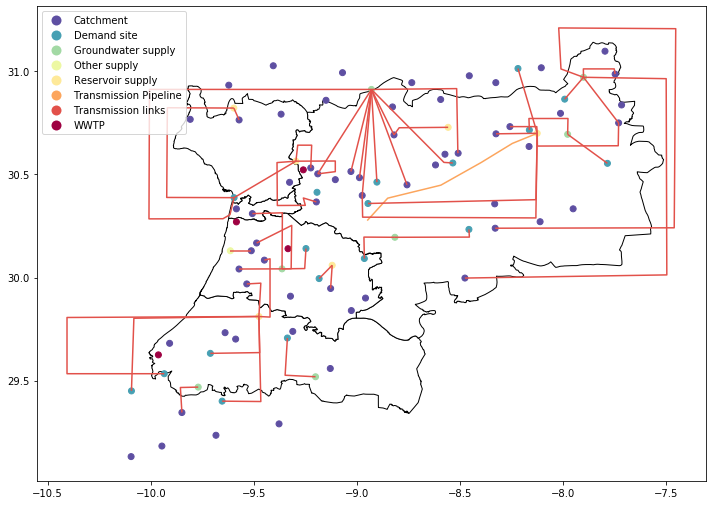

In [11]:
base = provinces.plot(color='white', edgecolor='black', figsize=(12, 12))
data = supply_points.append([demand_sites, catchments, diversion, links], ignore_index=True, sort=False)
data.plot(ax=base, column='type', cmap='Spectral_r', legend=True)
plt.show()

In [13]:
folder = r'Morocco dashboard/spatial_data'
wp.create_folder(folder)
catchments.to_file(os.path.join(folder, 'Catchments.geojson'), driver='GeoJSON')
demand_sites.to_file(os.path.join(folder, 'Demand_points.geojson'), driver='GeoJSON')
supply_points.to_file(os.path.join(folder, 'Supply_points.geojson'), driver='GeoJSON')
diversion.to_file(os.path.join(folder, 'Pipelines.geojson'), driver='GeoJSON')